# Unit 5 - Financial Planning

In [1]:
# Initial imports
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# Load .env enviroment variables
load_dotenv()

True

## Part 1 - Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [3]:
# Set current amount of crypto assets
my_btc = 1.2
my_eth = 5.3

In [4]:
# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=USD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=USD"

In [5]:
# Fetch current BTC price
btc_price = requests.get(btc_url).json()['data']['1']['quotes']['USD']['price']

# Fetch current ETH price
eth_price = requests.get(eth_url).json()['data']['1027']['quotes']['USD']['price']

# Compute current value of my crpto
my_btc_value = my_btc * btc_price
my_eth_value = my_eth * eth_price

# Print current crypto wallet balance
print(f"The current value of your {my_btc} BTC is ${my_btc_value:0.2f}")
print(f"The current value of your {my_eth} ETH is ${my_eth_value:0.2f}")

The current value of your 1.2 BTC is $24832.80
The current value of your 5.3 ETH is $6325.07


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [6]:
# Set current amount of shares
my_agg = 200
my_spy = 50

In [7]:
# Set Alpaca API key and secret
ALPACA_KEY = os.getenv('ALPACA_API_KEY')
ALPACA_SECRET = os.getenv('ALPACA_SECRET_KEY')

# Create the Alpaca API object
alpaca = tradeapi.REST(ALPACA_KEY,ALPACA_SECRET,api_version=2)

In [8]:
# Format current date as ISO format
start = pd.Timestamp('2020-07-07', tz='America/Chicago').isoformat()
end = pd.Timestamp('2020-07-14', tz='America/Chicago').isoformat()

# Set the tickers
tickers = ["AGG", "SPY"]

# Set timeframe to "1Day" for Alpaca API
timeframe = "1Day"

# Get current closing prices for SPY and AGG
df_portfolio = alpaca.get_bars(
    tickers,
    timeframe,
    start = start,
    end = end
).df

# Reorganize the DataFrame
# Separate ticker data
SPY = df_portfolio[df_portfolio['symbol']=='SPY'].drop(['symbol','trade_count','vwap'], axis=1)
AGG = df_portfolio[df_portfolio['symbol']=='AGG'].drop(['symbol','trade_count','vwap'], axis=1)

# Concatenate the ticker DataFrames
df_portfolio = pd.concat([AGG,SPY], axis=1, keys=['AGG','SPY'])

# Remove time from index
df_portfolio.index = df_portfolio.index.date
df_portfolio.index.name = 'date'

# Preview DataFrame
df_portfolio

AGG                                          SPY          \
              open      high       low   close   volume    open    high   
date                                                                      
2020-07-08  118.39  118.4500  118.2200  118.32  5026777  314.59  316.30   
2020-07-09  118.40  118.7000  118.3553  118.63  3804216  316.85  317.10   
2020-07-10  118.83  118.8300  118.4500  118.49  3133855  314.26  317.88   
2020-07-13  118.46  118.5287  118.3700  118.48  4803822  320.06  322.71   
2020-07-14  118.58  118.7400  118.5800  118.67  3986773  313.25  319.76   

                                       
               low   close     volume  
date                                   
2020-07-08  312.70  316.18   54639169  
2020-07-09  310.68  314.38   83354178  
2020-07-10  312.76  317.59   57559365  
2020-07-13  314.13  314.84  102997660  
2020-07-14  312.00  318.92   93545660

In [9]:
# Pick AGG and SPY close prices
agg_close_price = df_portfolio['AGG']['close'].iloc[-1]
spy_close_price = df_portfolio['SPY']['close'].iloc[-1]

# Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close_price}")
print(f"Current SPY closing price: ${spy_close_price}")

Current AGG closing price: $118.67
Current SPY closing price: $318.92


In [10]:
# Compute the current value of shares
my_spy_value = my_spy * spy_close_price
my_agg_value = my_agg * agg_close_price

# Print current value of shares
print(f"The current value of your {my_spy} SPY shares is ${my_spy_value:0.2f}")
print(f"The current value of your {my_agg} AGG shares is ${my_agg_value:0.2f}")

The current value of your 50 SPY shares is $15946.00
The current value of your 200 AGG shares is $23734.00


### Savings Health Analysis

In [11]:
# Set monthly household income
monthly_income = 12000

# Consolidate financial assets data
shares = my_spy_value + my_agg_value
crypto = my_btc_value + my_eth_value

# Create savings DataFrame
df_savings = pd.DataFrame(data = {'amount': [crypto,shares]}, index=['crypto','shares'])

# Display savings DataFrame
display(df_savings)

,amount
crypto,31157.873
shares,39680.000


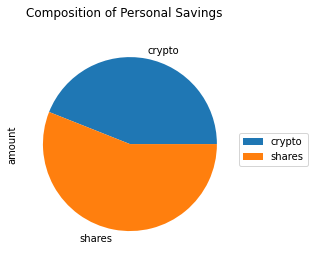

In [12]:
# Plot savings pie chart
df_savings.plot(kind='pie',subplots=True,title='Composition of Personal Savings')
plt.legend(loc=[1.0,0.4]);

In [13]:
# Set ideal emergency fund
emergency_fund = monthly_income * 3

# Calculate total amount of savings
total_savings = crypto + shares

# Validate saving health
if total_savings > emergency_fund:
    print('Congratulations! You have enough money in your emergency fund.')
elif total_savings == emergency_fund:
    print('Congratulations! You have reached your emergency savings goal!')
else:
    print(f'You are ${emergency_fund-total_savings} away from reaching your emergency savings goal.')

Congratulations! You have enough money in your emergency fund.


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [14]:
# Set start and end dates of five years back from today.
# Sample results may vary from the solution based on the time frame chosen
start_date = pd.Timestamp('2017-05-10', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2022-05-10', tz='America/New_York').isoformat()

In [15]:
# Get 5 years' worth of historical data for SPY and AGG
# Set the tickers
tickers = ["AGG", "SPY"]

# Set timeframe to "1Day" for Alpaca API
timeframe = "1Day"

# Get historical data for SPY and AGG
df_stock_data = alpaca.get_bars(
    tickers,
    timeframe,
    start = start_date,
    end = end_date
).df

# Reorganize the DataFrame
# Separate ticker data
SPY = df_stock_data[df_stock_data['symbol']=='SPY'].drop(['symbol','trade_count','vwap'], axis=1)
AGG = df_stock_data[df_stock_data['symbol']=='AGG'].drop(['symbol','trade_count','vwap'], axis=1)

# Concatenate the ticker DataFrames
df_stock_data = pd.concat([AGG,SPY], axis=1, keys=['AGG','SPY'])

# Remove time from index
df_stock_data.index = df_stock_data.index.date
df_stock_data.index.name = 'date'

# Display sample data
df_stock_data.head()

AGG                                         SPY            \
              open     high       low   close   volume    open      high   
date                                                                       
2017-05-10  108.60  108.660  108.4400  108.53  1653429  239.37  239.8700   
2017-05-11  108.35  108.540  108.3435  108.52  2331142  239.31  239.5700   
2017-05-12  108.81  108.940  108.7800  108.92  1329696  239.05  239.4273   
2017-05-15  108.85  108.940  108.8200  108.88  1770999  239.49  240.4400   
2017-05-16  108.88  109.101  108.8800  109.02  2051881  240.64  240.6700   

                                      
               low   close    volume  
date                                  
2017-05-10  239.15  239.87  54293799  
2017-05-11  238.13  239.38  62269354  
2017-05-12  238.67  238.98  53912730  
2017-05-15  239.45  240.30  61868937  
2017-05-16  239.63  240.08  51241791

In [16]:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns
mc_sim = MCSimulation(
    portfolio_data=df_stock_data,
    weights=[0.4,0.6],
    num_simulation=500,
    num_trading_days=252*30
)

In [17]:
# Printing the simulation input data
mc_sim.portfolio_data.head()

AGG                                                      SPY  \
              open     high       low   close   volume daily_return    open   
date                                                                          
2017-05-10  108.60  108.660  108.4400  108.53  1653429          NaN  239.37   
2017-05-11  108.35  108.540  108.3435  108.52  2331142    -0.000092  239.31   
2017-05-12  108.81  108.940  108.7800  108.92  1329696     0.003686  239.05   
2017-05-15  108.85  108.940  108.8200  108.88  1770999    -0.000367  239.49   
2017-05-16  108.88  109.101  108.8800  109.02  2051881     0.001286  240.64   

                                                             
                high     low   close    volume daily_return  
date                                                         
2017-05-10  239.8700  239.15  239.87  54293799          NaN  
2017-05-11  239.5700  238.13  239.38  62269354    -0.002043  
2017-05-12  239.4273  238.67  238.98  53912730    -0.001671  
2017-05-15  240.4400  239.45  240.30  61868937     0.005523  
2017-05-16  240.6700  239.63  240.08  51241791    -0.000916

In [18]:
# Drop nulls
mc_sim.portfolio_data.dropna(inplace=True)

In [19]:
import warnings

In [24]:
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [21]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
mc_sim.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.993373,0.995504,1.000014,0.993752,1.007614,0.995569,1.003430,0.997617,0.996928,0.997396,...,0.998430,0.993221,0.997038,0.992433,1.003399,0.990572,1.008572,0.996830,0.987835,0.996679
2,0.984413,0.985499,0.996295,0.998512,1.011292,0.995972,1.008547,0.998942,0.990185,0.994811,...,0.984706,1.001807,0.991148,0.983028,1.019353,0.987560,0.995379,1.003289,0.989905,0.989230
3,0.981602,0.988269,0.985089,0.998964,1.017568,1.003505,1.004575,0.997951,0.991948,1.001052,...,0.981590,0.992433,0.989245,0.979122,1.008825,0.989148,0.999759,0.997487,0.993286,0.987269
4,0.973654,0.997499,0.993597,0.994848,1.015932,1.004971,1.002414,0.997910,0.998729,0.992395,...,0.980041,0.991237,1.005123,0.981202,0.995556,0.998862,0.994201,0.983651,1.011125,0.991409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,6.978981,2.092377,8.522877,2.684887,2.442583,9.507748,2.147879,5.551816,2.820125,14.444310,...,12.541717,6.788106,8.403050,21.004912,9.387294,10.953627,13.236261,6.447152,7.508734,5.671132
7557,7.011045,2.081293,8.471423,2.712318,2.439894,9.535670,2.126176,5.562458,2.871069,14.392109,...,12.564414,6.794922,8.425205,21.204653,9.274615,10.874973,13.276634,6.407258,7.621924,5.721004
7558,7.041960,2.090159,8.418105,2.713309,2.479866,9.457055,2.149668,5.553781,2.880839,14.580578,...,12.757805,6.691974,8.445929,21.079481,9.281289,10.959075,13.378561,6.263353,7.717082,5.708504
7559,7.006016,2.085180,8.400773,2.698541,2.495645,9.472214,2.153770,5.479176,2.904748,14.633401,...,12.893105,6.681646,8.550471,20.876222,9.244832,10.959600,13.344211,6.251864,7.833721,5.705511


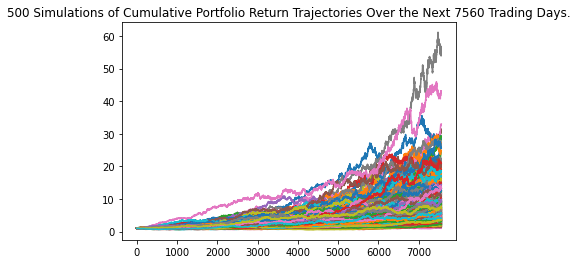

In [25]:
# Plot simulation outcomes
mc_sim.plot_simulation();

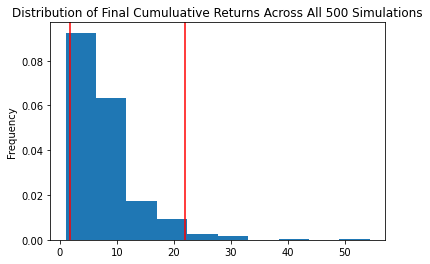

In [23]:
# Plot probability distribution and confidence intervals
mc_sim.plot_distribution();

### Retirement Analysis

In [27]:
# Fetch summary statistics from the Monte Carlo simulation results
mc_sim_stats = mc_sim.summarize_cumulative_return()
# Print summary statistics
mc_sim_stats

count           500.000000
mean              7.912030
std               5.809737
min               1.015695
25%               4.130867
50%               6.404198
75%               9.599166
max              54.414538
95% CI Lower      1.837739
95% CI Upper     21.974092
Name: 7560, dtype: float64


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `$20,000` initial investment.

In [89]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower = round(initial_investment * mc_sim_stats['95% CI Lower'], 2)
ci_upper = round(initial_investment * mc_sim_stats['95% CI Upper'], 2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $37607.8 and $425135.26


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [90]:
# Set initial investment
initial_investment = 20000 * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
ci_lower = round(initial_investment * mc_sim_stats['95% CI Lower'], 2)
ci_upper = round(initial_investment * mc_sim_stats['95% CI Upper'], 2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 30 years will end within in the range of $56411.7 and $637702.89


## Optional Challenge - Early Retirement


### Five Years Retirement Option

In [41]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
mc_sim_5y = MCSimulation(
    portfolio_data=df_stock_data,
    weights=[0.15,0.85],
    num_simulation=500,
    num_trading_days=252*5
)

In [42]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
mc_sim_5y.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.995335,0.987469,0.996520,0.999160,0.993921,1.011722,0.994049,1.011630,1.006232,0.992101,...,1.023967,1.006214,1.002993,0.997790,1.017781,0.998095,0.971291,0.993067,1.017187,0.997945
2,0.982110,0.982028,0.991615,0.998813,0.993791,1.024958,0.982627,1.018451,1.005713,1.002739,...,1.033984,1.007947,1.015048,1.009248,1.021055,0.986687,0.975303,0.991572,1.032656,0.989777
3,0.966497,0.976616,0.980642,1.003708,0.967943,1.057905,0.972405,1.007283,1.007038,1.006264,...,1.047669,1.011054,1.020986,1.025338,1.018249,0.996415,0.968095,0.980312,1.049872,0.982027
4,0.970553,0.990722,0.979864,0.997586,0.978255,1.051339,0.985189,0.995959,1.003083,1.025926,...,1.051070,1.017719,1.024110,0.995461,1.031673,0.997145,0.986101,0.995623,1.053803,0.999342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.193866,1.075936,0.947273,1.690324,1.001517,2.941254,1.285725,1.189914,0.933366,2.397091,...,1.321966,2.680352,1.594168,1.154640,1.656281,2.225502,1.238494,1.222943,1.611465,1.456837
1257,1.206806,1.064723,0.949759,1.661707,0.998411,2.898404,1.303682,1.182555,0.946074,2.380107,...,1.324241,2.672275,1.602249,1.168078,1.652891,2.241245,1.236747,1.221197,1.636336,1.432559
1258,1.202005,1.080354,0.956573,1.647554,0.990721,2.846059,1.308936,1.189136,0.957493,2.351888,...,1.306603,2.700873,1.588128,1.148025,1.660822,2.273408,1.240266,1.200409,1.654331,1.438334
1259,1.200119,1.078414,0.967672,1.641501,0.990684,2.831930,1.309162,1.190662,0.964877,2.359585,...,1.324330,2.693152,1.589555,1.140465,1.688717,2.257795,1.235871,1.193659,1.688509,1.449433


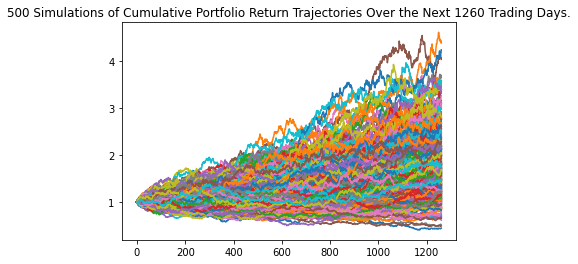

In [43]:
# Plot simulation outcomes
mc_sim_5y.plot_simulation();

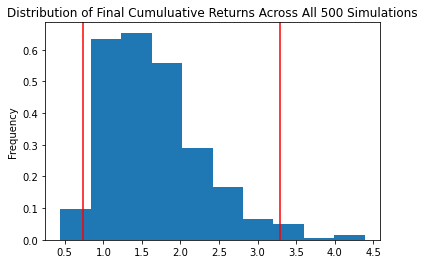

In [44]:
mc_sim_5y.plot_distribution();

In [45]:
# Fetch summary statistics from the Monte Carlo simulation results
mc_sim_5y_stats = mc_sim_5y.summarize_cumulative_return()

# Print summary statistics
mc_sim_5y_stats

count           500.000000
mean              1.654074
std               0.638157
min               0.441920
25%               1.184653
50%               1.568896
75%               1.995973
max               4.389764
95% CI Lower      0.738756
95% CI Upper      3.290617
Name: 1260, dtype: float64

In [46]:
# Set initial investment
initial_investment = 60000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_five = round(mc_sim_5y_stats['95% CI Lower'] * 60000, 2)
ci_upper_five = round(mc_sim_5y_stats['95% CI Upper'] * 60000, 2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_five} and ${ci_upper_five}")

There is a 95% chance that an initial investment of $60000 in the portfolio over the next 5 years will end within in the range of $44325.33 and $197437.04


### Ten Years Retirement Option

In [47]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
mc_sim_10y = MCSimulation(
    portfolio_data=df_stock_data,
    weights=[0.2,0.8],
    num_simulation=500,
    num_trading_days=252*10
)

In [48]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
mc_sim_10y.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.018660,1.000964,1.006068,1.003502,0.996502,1.006218,1.012045,1.009086,1.002560,0.996404,...,1.008382,1.004234,1.008809,1.023872,0.980530,0.974198,0.993063,0.996680,1.009506,0.985134
2,1.030396,0.982011,0.992826,1.022239,0.992963,1.007590,1.017388,1.008243,1.021650,1.004263,...,1.010824,1.017499,1.021395,1.014973,0.986575,0.970903,0.993781,1.013851,1.003517,1.000469
3,1.036402,0.982874,1.004284,1.008466,0.997646,1.000086,1.033807,1.016174,1.022850,1.014904,...,1.007968,1.019280,1.022057,1.006193,0.995501,0.956661,1.008258,0.996835,0.989681,1.000316
4,1.034060,0.980587,1.016620,1.007662,1.011581,0.982069,1.036676,1.010299,0.998493,1.013106,...,1.026243,1.022444,1.039183,0.988449,1.000375,0.939637,1.015622,0.994782,0.980421,0.998848
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,1.220708,2.639797,1.157584,4.652196,3.423696,2.738231,2.588074,1.549673,1.424501,1.118710,...,3.454997,2.098134,2.246858,1.307040,1.300061,1.606127,2.032421,6.253910,2.839095,3.498119
2517,1.229125,2.642325,1.144973,4.614244,3.374331,2.682373,2.595137,1.585552,1.421004,1.098656,...,3.504730,2.097840,2.246508,1.335163,1.263361,1.600701,2.047255,6.306770,2.818428,3.447710
2518,1.227076,2.654452,1.154758,4.767873,3.341975,2.683533,2.648171,1.577238,1.407026,1.098610,...,3.545741,2.115464,2.267464,1.316939,1.239408,1.589373,2.043780,6.392159,2.816376,3.427263
2519,1.230717,2.659593,1.156751,4.829098,3.394178,2.681109,2.630511,1.589376,1.415652,1.087409,...,3.488528,2.117686,2.287368,1.326822,1.244121,1.585449,2.071433,6.440975,2.839280,3.493885


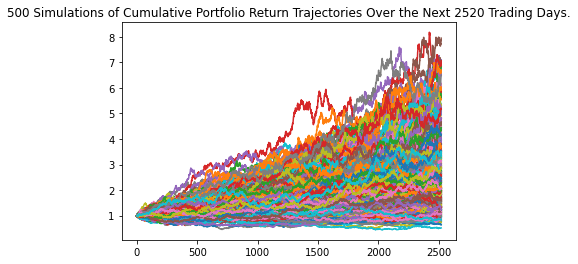

In [51]:
# Plot simulation outcomes
mc_sim_10y.plot_simulation();

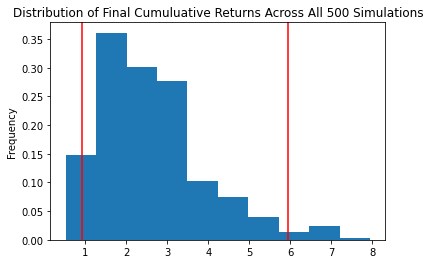

In [53]:
# Plot probability distribution and confidence intervals
mc_sim_10y.plot_distribution();

In [54]:
# Fetch summary statistics from the Monte Carlo simulation results
mc_sim_10y_stats = mc_sim_5y.summarize_cumulative_return()

# Print summary statistics
mc_sim_10y_stats

count           500.000000
mean              1.654074
std               0.638157
min               0.441920
25%               1.184653
50%               1.568896
75%               1.995973
max               4.389764
95% CI Lower      0.738756
95% CI Upper      3.290617
Name: 1260, dtype: float64

In [55]:
# Set initial investment
initial_investment = 60000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_ten = round(mc_sim_10y_stats['95% CI Lower'] * 60000, 2)
ci_upper_ten = round(mc_sim_10y_stats['95% CI Upper'] * 60000, 2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${ci_lower_ten} and ${ci_upper_ten}")

There is a 95% chance that an initial investment of $60000 in the portfolio over the next 10 years will end within in the range of $44325.33 and $197437.04
